# Read the data and rename some parameters

In [26]:
import xarray as xr

# import .nc data
ds = xr.open_dataset('data/trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')

# rename the TREFHT to sat
ds = ds.rename({'TREFHT': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})
# multiply age by 1000
ds['age'] = ds['age'] * -1000


In [27]:
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:       (age: 2204, lat: 48, lon: 96, ilev: 27, lev: 26,
                   isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7)
Coordinates:
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * lat           (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lev           (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * lon           (lon) float64 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * age           (age) float64 2.2e+04 2.199e+04 2.198e+04 ... -20.0 -30.0
Data variables: (12/25)
    P0            float64 ...
    sat           (age, lat, lon) float32 ...
    co2vmr        (age) float64 ...
    date          (age) int32 ...
    date_written  (age

# Plot the temperature difference between the first and last data point

In [3]:
# plot the amplitude of deglacial warming
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_sat(ds):
    # extract the first value of 'sat'
    sat =ds['sat'].isel(age=-1)- ds['sat'].isel(age=0)

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()),dpi=300)

    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # plot heatmap
    cmap = plt.cm.get_cmap('YlOrRd')
    im = ax.pcolormesh(ds.lon, ds.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Amplitude of deglacial warming (T in age={int(ds.age.values[-1]*1000)} minors T in age={int(ds.age.values[0]*1000)})')

    # add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    cbar.ax.set_ylabel('Delta SAT')

    # set title and show plot
    plt.show()


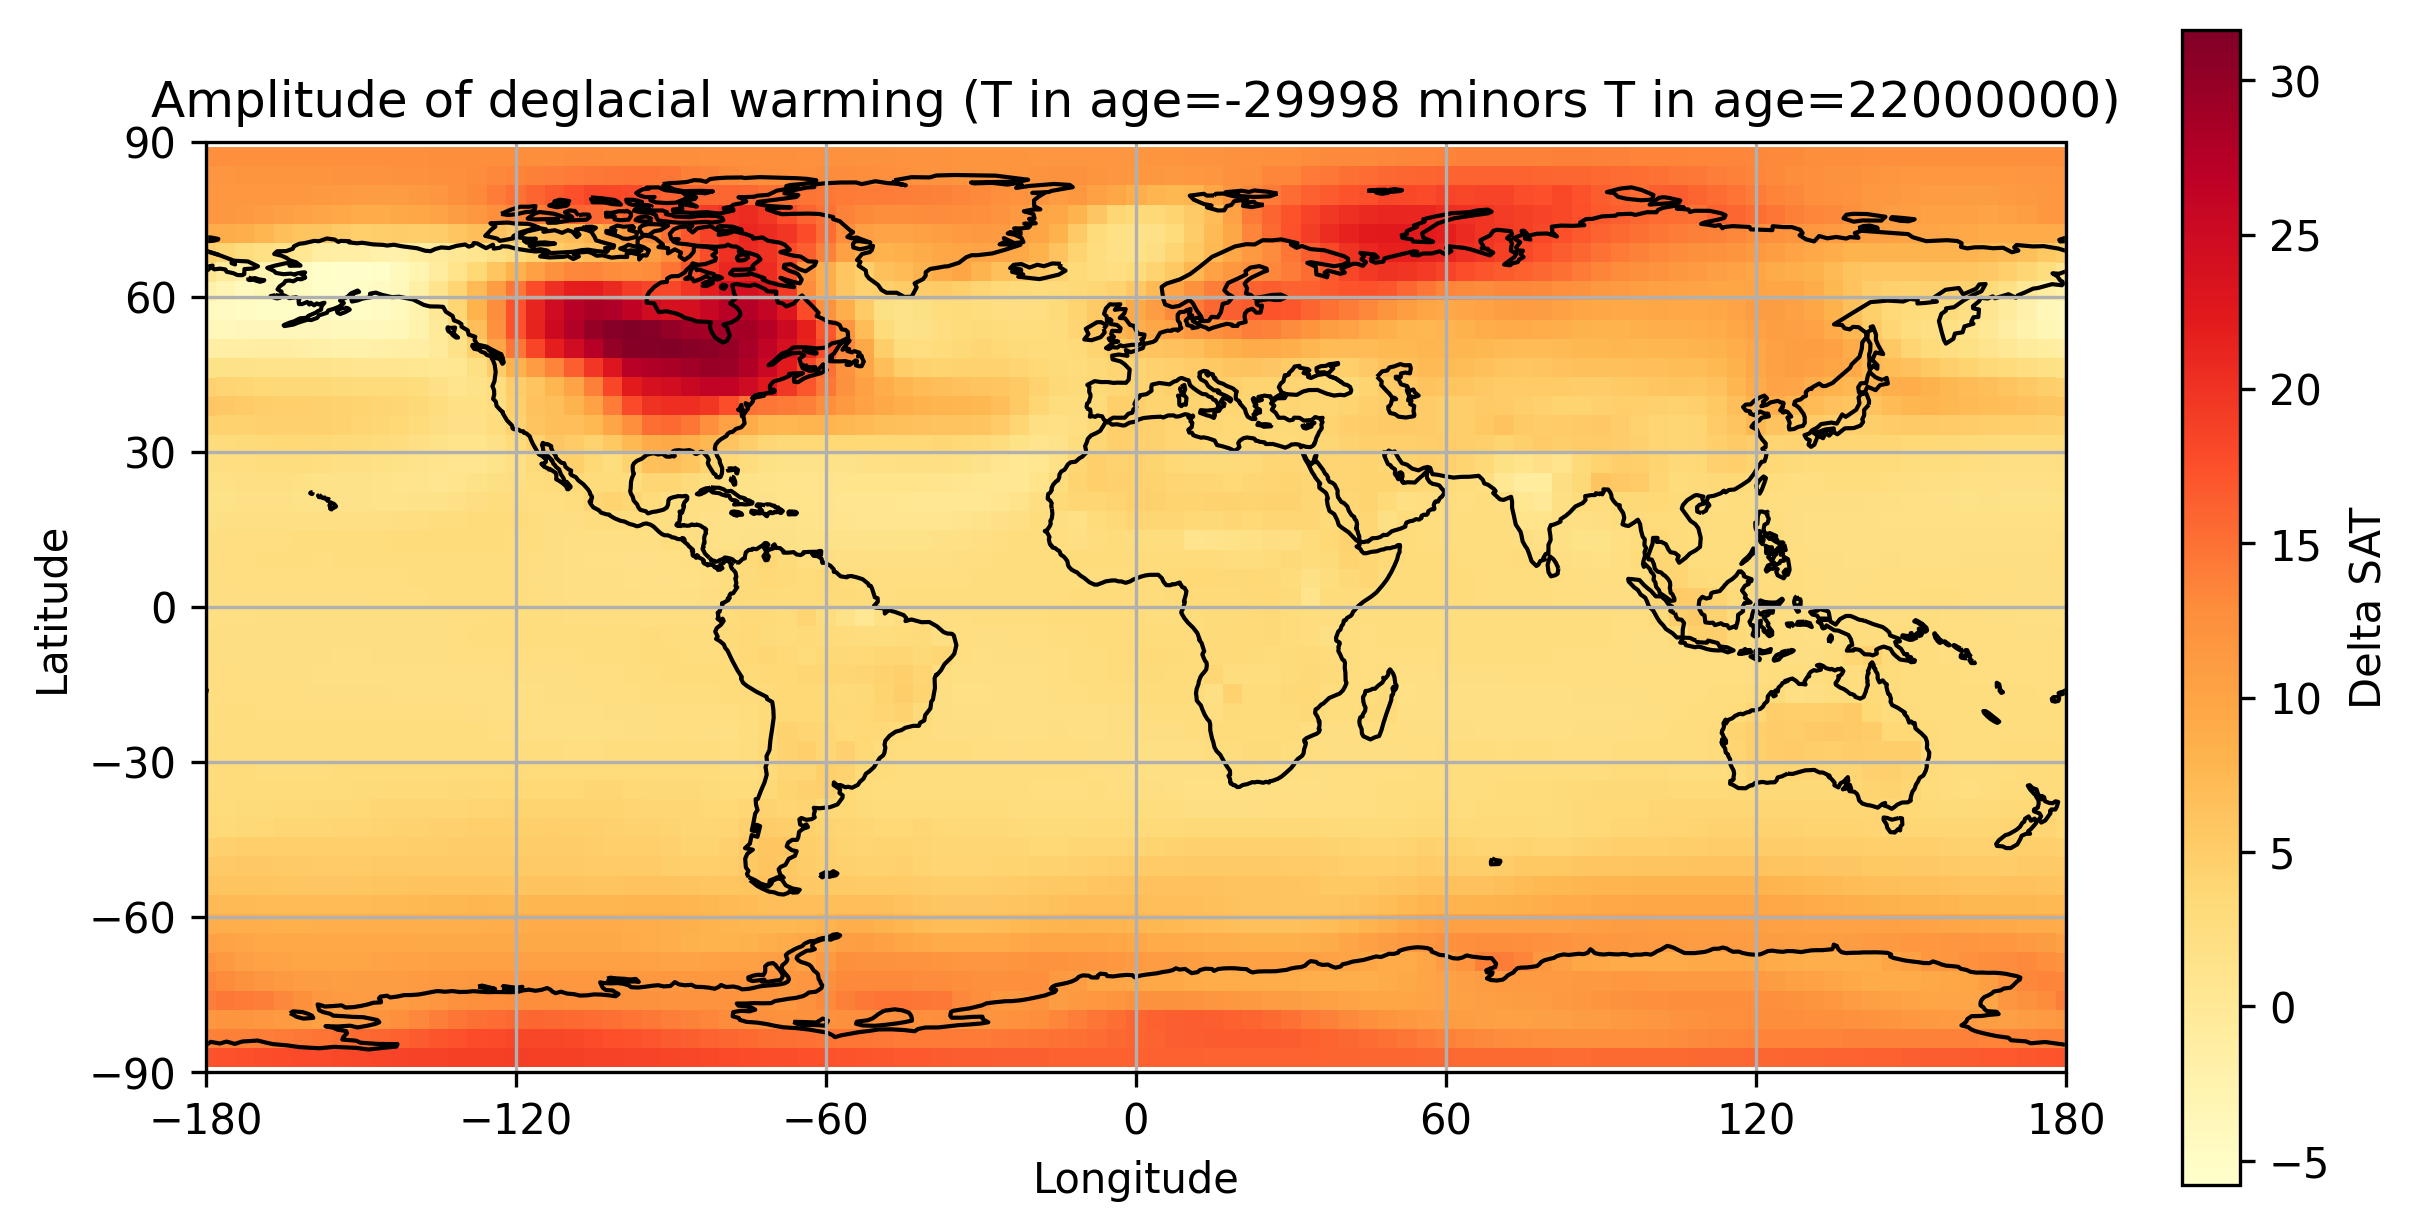

In [4]:
plot_sat(ds)

# Plot time series

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def random_64(ds, variable='sat',num_samples=64):
    # Select random samples from the lat and lon dimensions
    lat_samples = np.random.randint(0, ds.dims['lat'], size=num_samples)
    lon_samples = np.random.randint(0, ds.dims['lon'], size=num_samples)

    # Extract the age and sat values for the selected samples
    age_vals = ds.age.values
    sat_vals = ds[variable].values[:, lat_samples, lon_samples]

    ncol = 8
    nrow = int(np.ceil(num_samples / ncol))
    fig,axs=plt.subplots(nrow,ncol,figsize=(20,20),dpi=300)
    for i in range(num_samples):
        ax=axs[int(i/ncol),i%ncol]
        ax.plot(age_vals, sat_vals[:, i])
        # ax.plot(ds.age_transition.values[lat_samples[i], lon_samples[i]], ds.sat_transition.values[lat_samples[i], lon_samples[i]], 'ro')
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlabel('Age')
        ax.set_ylabel('SAT')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

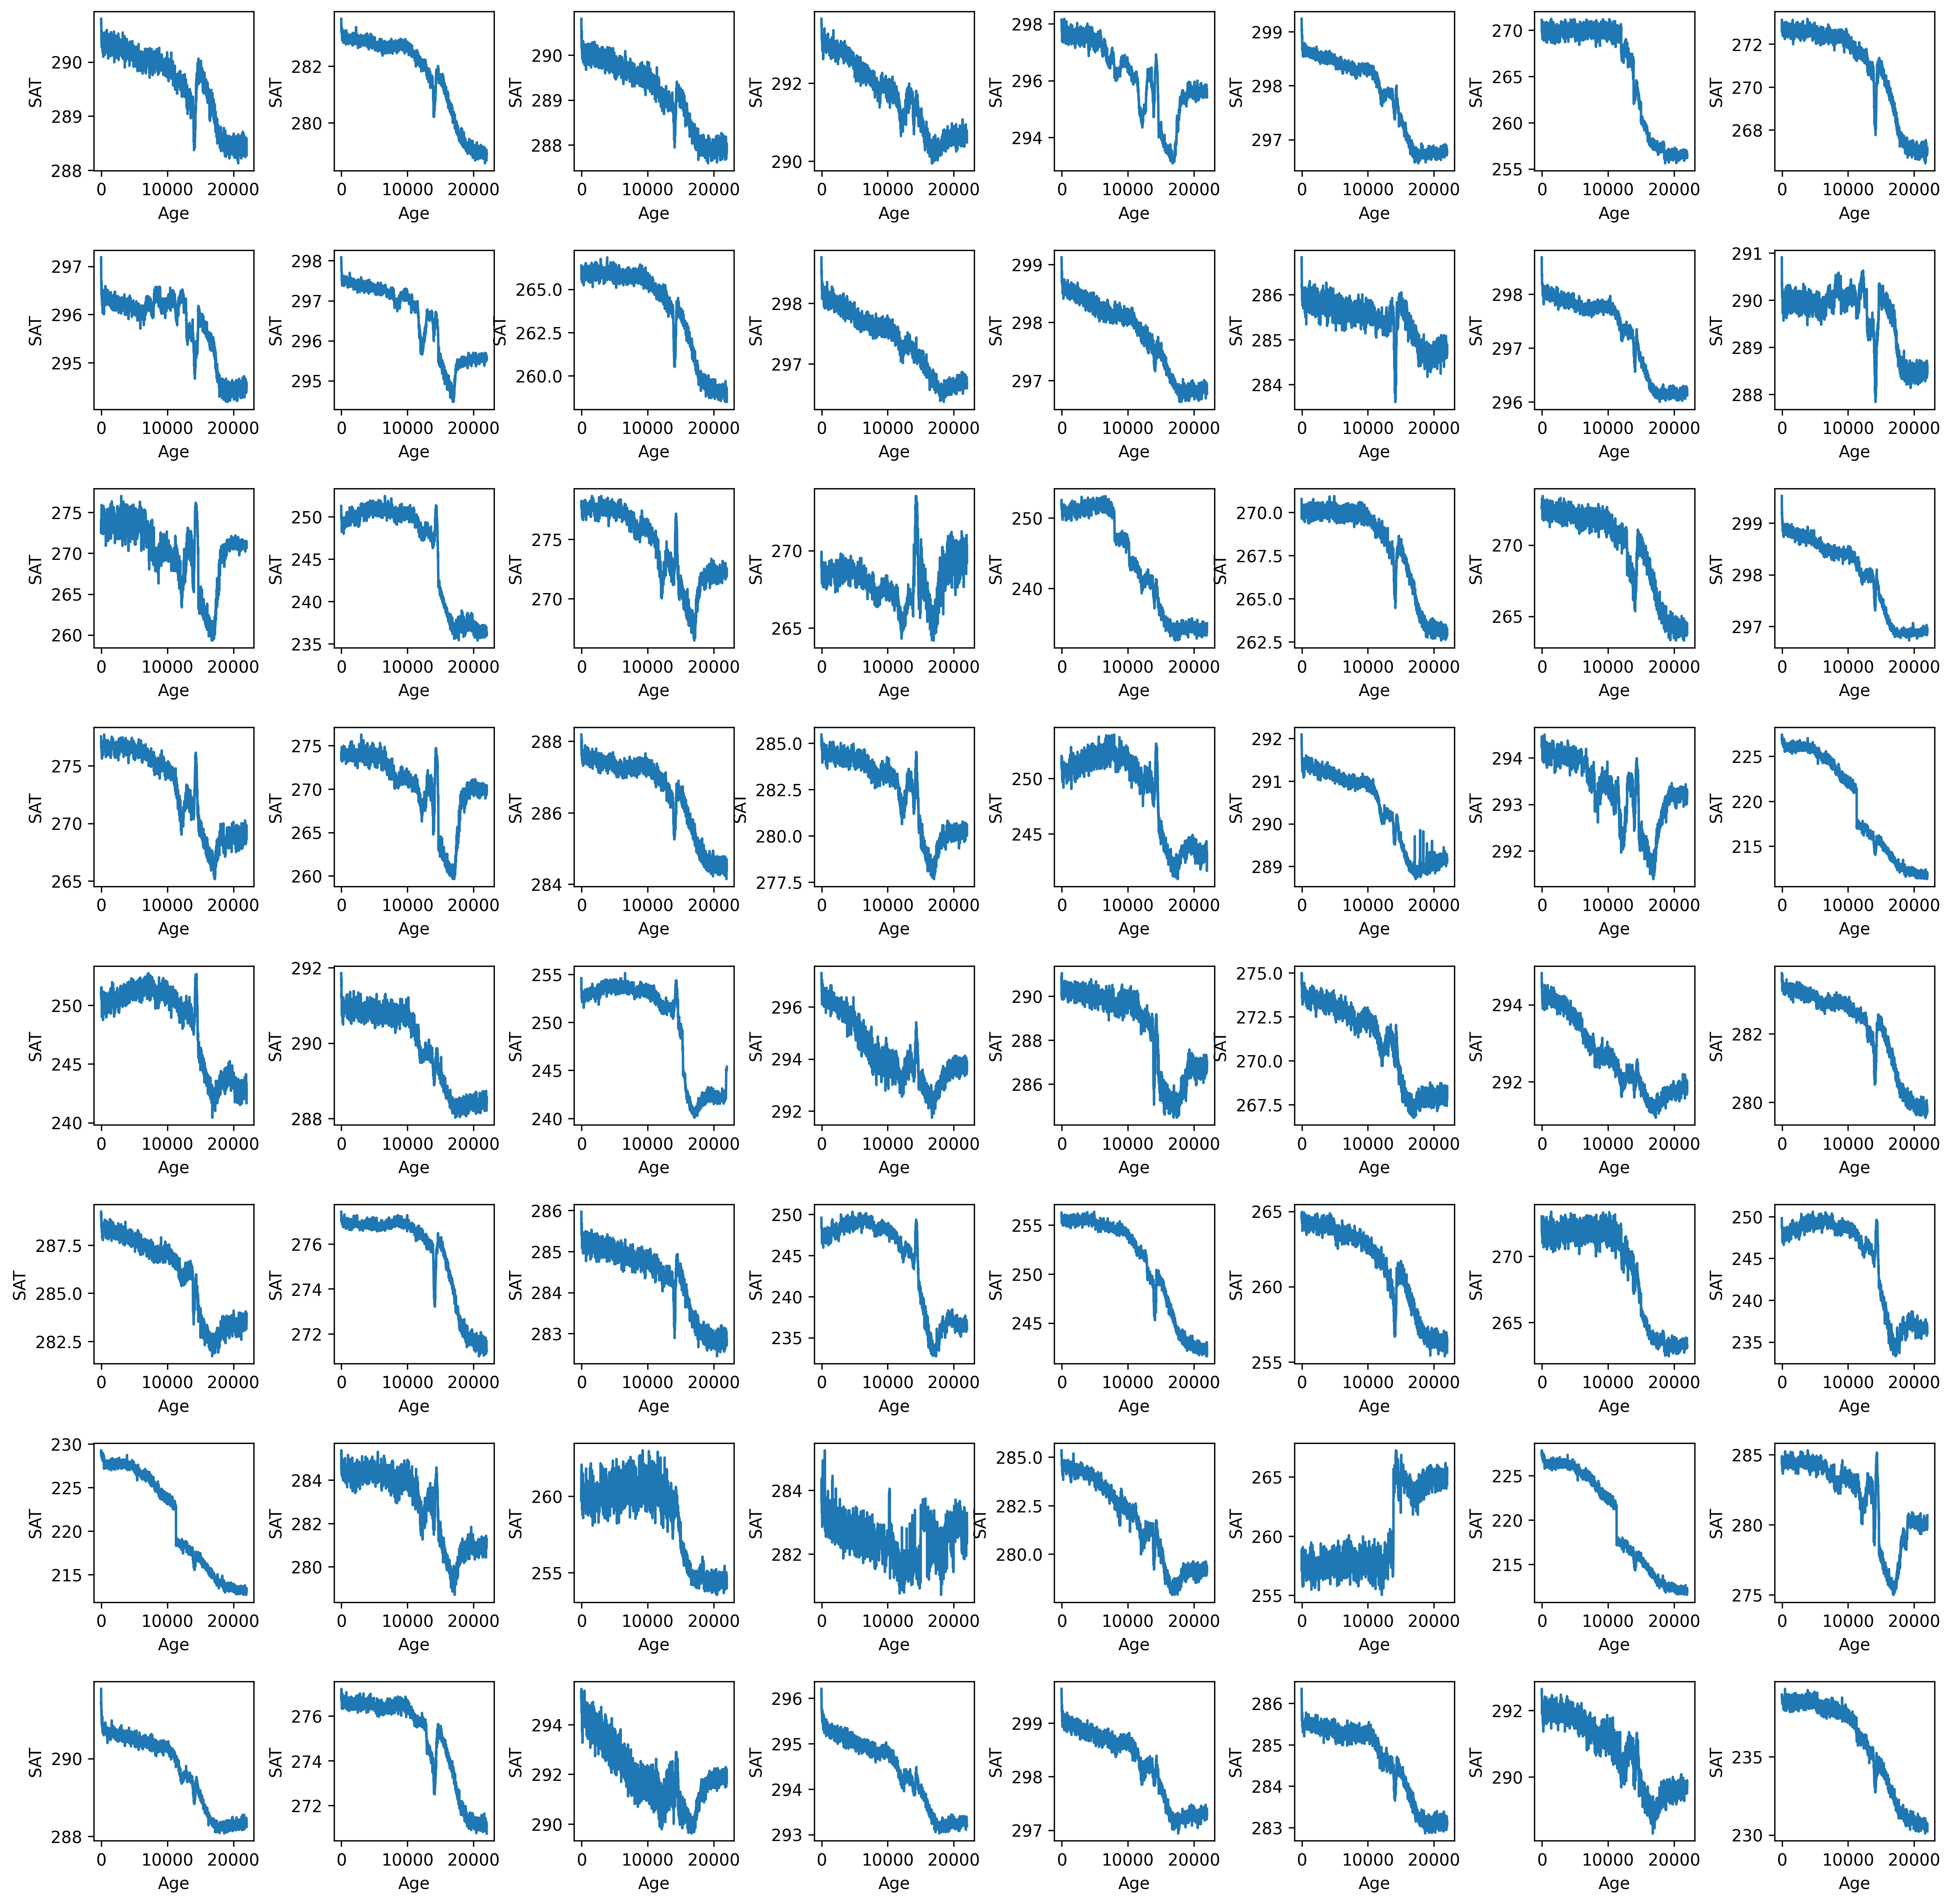

In [45]:
random_64(ds)

In [55]:
ds_sat=ds

# The age of LGMR data starts from 100 and eds at 23900 with step of 200 yr, so here we smooth the TraCE data with 200 yr moving average to match the two dataset

In [52]:
# import numpy as np

# new_age = np.arange(100, ds['age'].values[0] + 1, 200)

# # Initialize a new array to store smoothed values
# smoothed_data = np.zeros_like(ds['sat'].values)

# # Create the smoothing window
# window_size = 20
# window = np.ones(window_size) / window_size

# # Loop through lat and lon to perform the smoothing
# for i_lat, _ in enumerate(ds['lat'].values):
#     for i_lon, _ in enumerate(ds['lon'].values):
#         smoothed_data[:, i_lat, i_lon] = np.convolve(ds['sat'].values[:, i_lat, i_lon], window, 'same')

# # Create a new xarray.Dataset with smoothed data
# ds_sat = xr.Dataset(
#     {
#         'sat': (('age', 'lat', 'lon'), smoothed_data),
#     },
#     coords={
#         'age': ds['age'],
#         'lat': ds['lat'],
#         'lon': ds['lon'],
#     }
# )

# # Interpolate to the new ages
# ds_sat = ds_sat.interp(age=new_age)



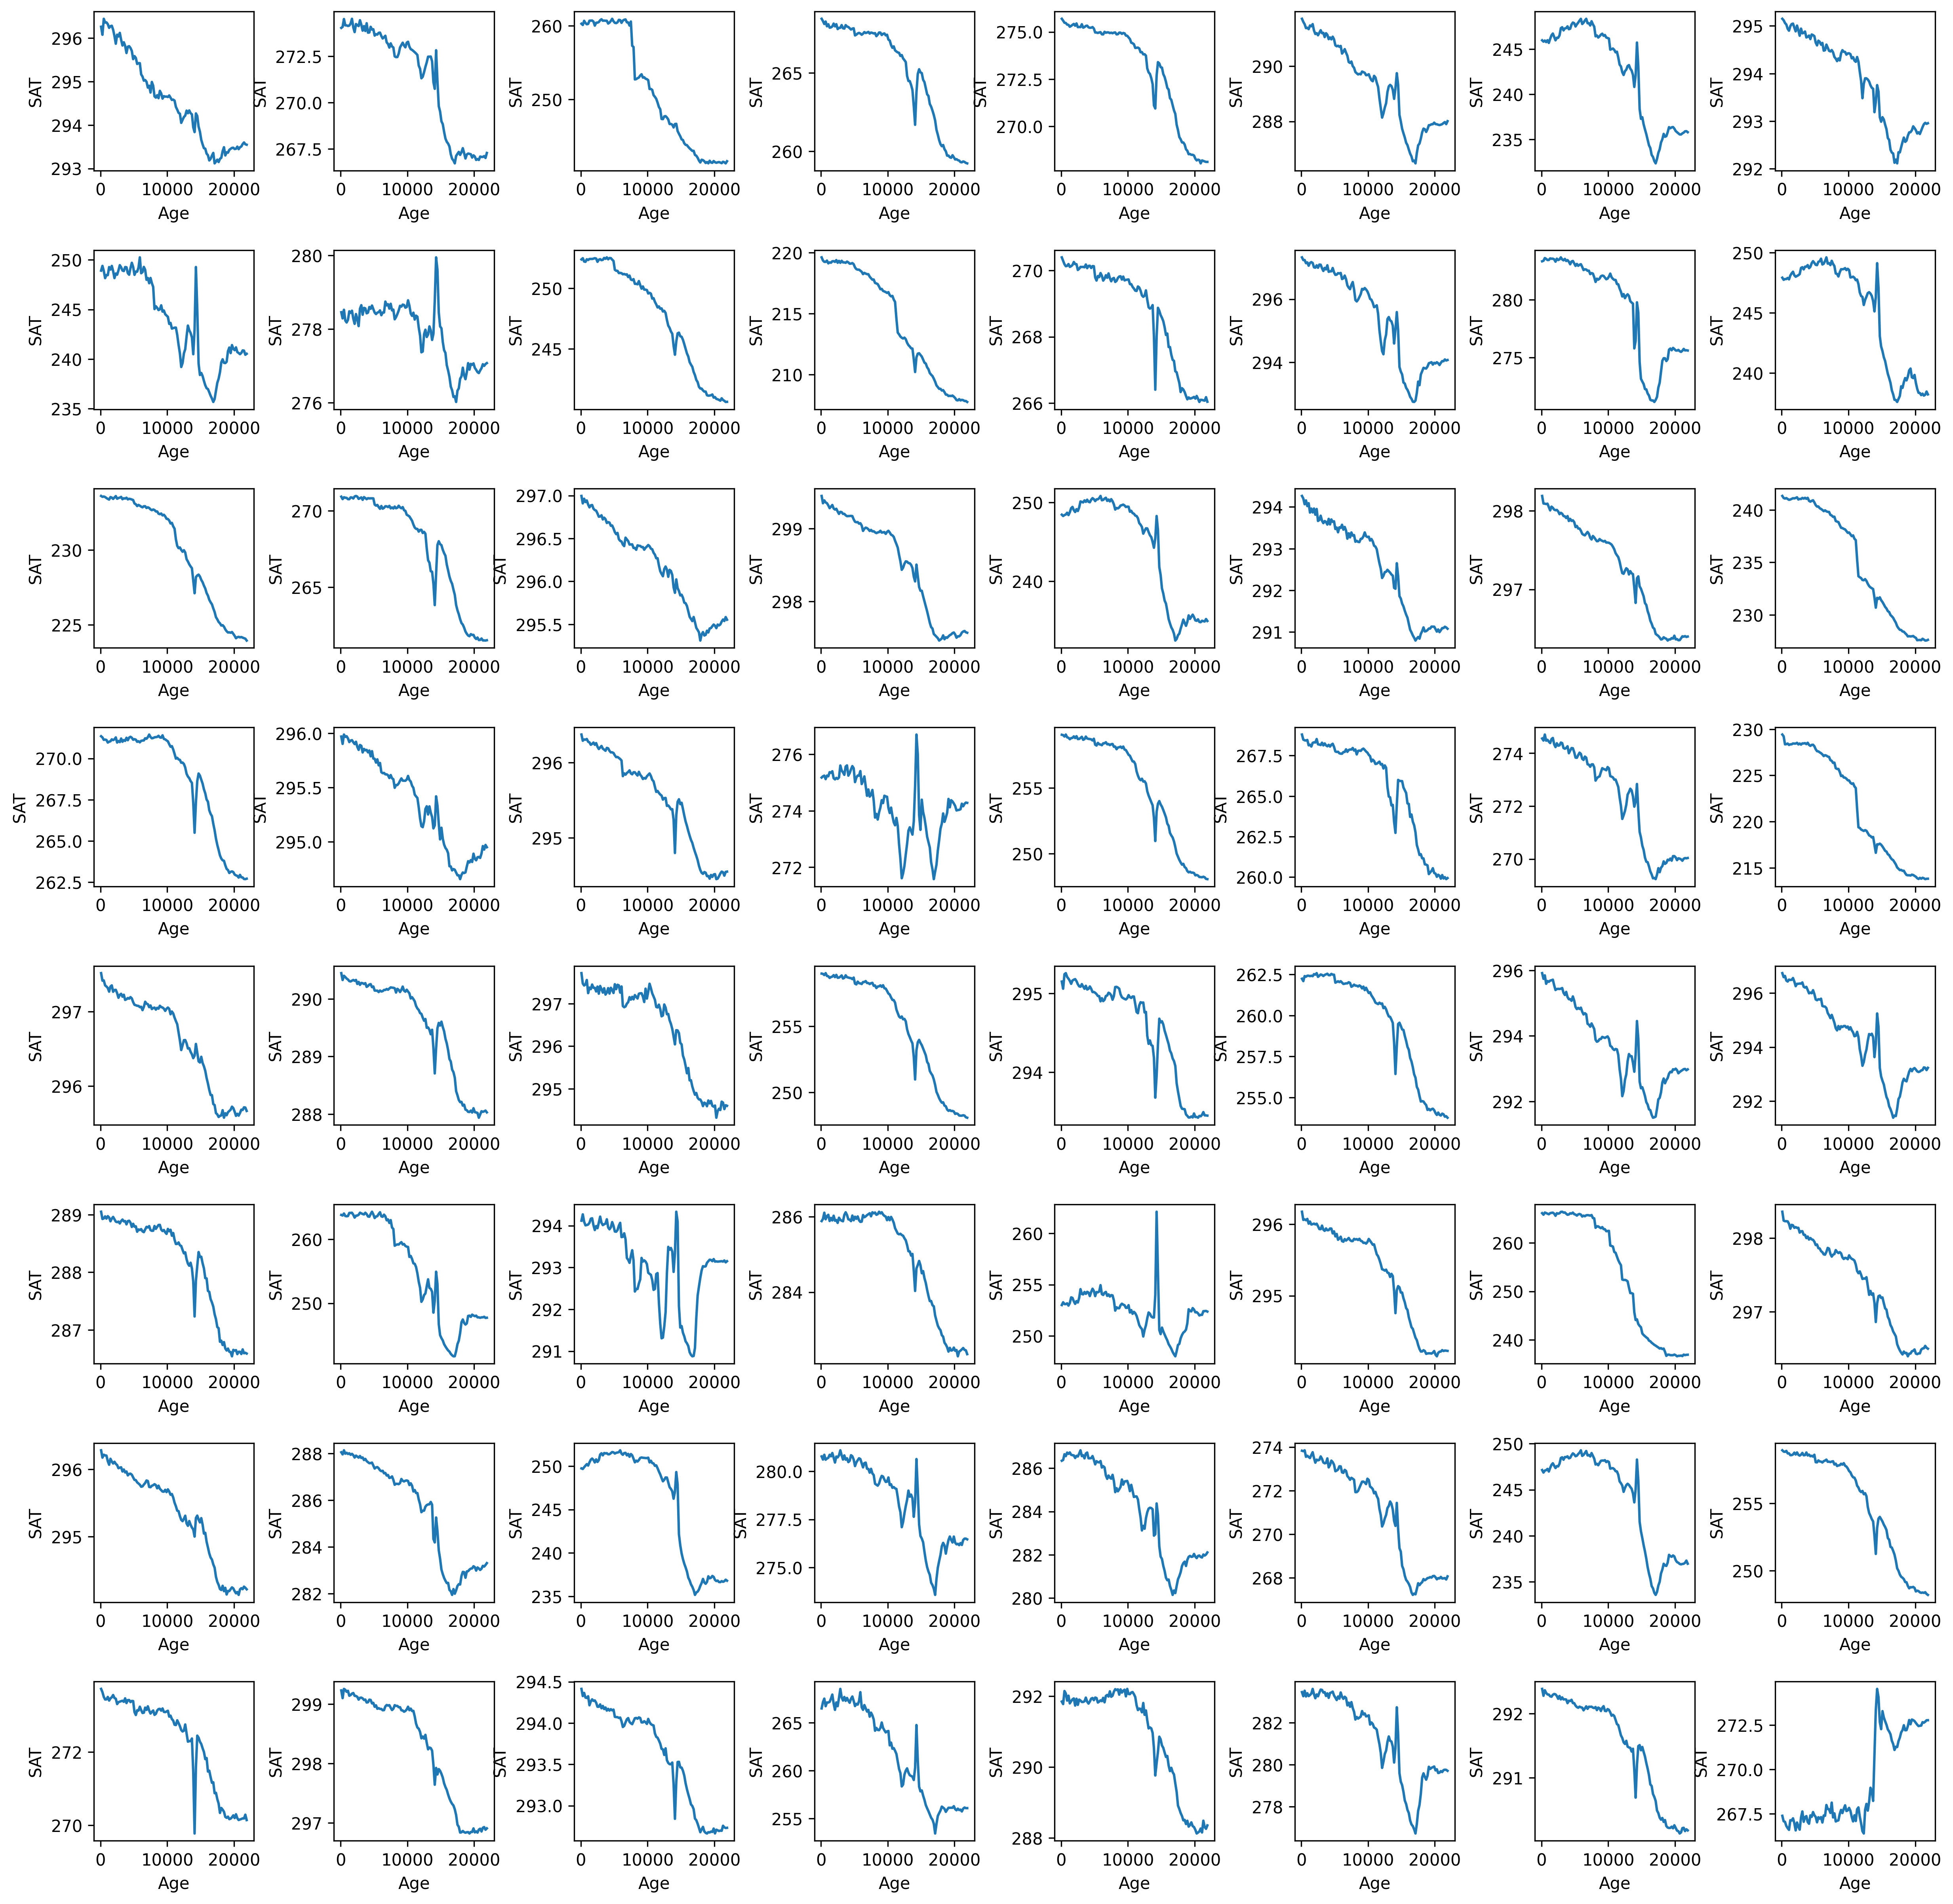

In [46]:
random_64(ds_sat)

In [49]:

# ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)


# Functions to calculate PCs

In [6]:
import numpy as np
import xarray as xr

def center_data(ds, var_name):
    """
    Center the data by subtracting the mean along the 'age' axis.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the variable to be centered.
    var_name (str): The name of the variable in the dataset to center.

    Returns:
    xarray.Dataset: A new dataset with the centered data added as a new variable.
    """
    # Create a copy of the dataset to avoid modifying the original
    ds_copy = ds.copy()
    
    # Calculate the mean along the 'age' axis
    mean_data = ds_copy[var_name].mean(dim='age')
    
    # Subtract the mean from the data
    centered_data = ds_copy[var_name] - mean_data
    
    # Add the centered data as a new variable to the dataset
    ds_copy[f"{var_name}_centered"] = centered_data
    
    return ds_copy



def weight_centered_data(ds, var_name):
    """
    Weight the centered data by latitude and reshape the resulting array.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the variable to be weighted.
    var_name (str): The name of the centered variable in the dataset to weight.
    
    Returns:
    xarray.Dataset: A modified dataset with the weighted centered data added as a new variable.
    np.ndarray: A NumPy array containing the reshaped weighted centered data.
    """
    # Create a copy of the dataset to avoid modifying the original
    ds_copy = ds.copy()

    # Generate the weight based on latitude
    weight = np.cos(np.deg2rad(ds_copy['lat']))
    
    # Set weight to 0 if it is smaller than 0
    weight = xr.where(weight < 0, 0, weight)
    
    # Add the weight as a new data variable
    ds_copy['weight'] = weight

    # Multiply the centered data with the weight
    weighted_data = ds_copy[var_name] * weight
    
    # Add the weighted data as a new variable
    ds_copy[f"{var_name}_weighted"] = weighted_data

    # Reshape the weighted data
    reshaped_weighted_data = weighted_data.values
    num_ages = len(ds_copy['age'])
    reshaped_weighted_data = reshaped_weighted_data.reshape(num_ages, -1)
    
    return ds_copy, reshaped_weighted_data


import matplotlib.pyplot as plt

def plot_PCs(PCs,variance_explained):
        

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(ds_sat['age'], -1*PCs[:, 0], label='PC1, v_exp={:.2f}'.format(variance_explained[0]))
    ax.plot(ds_sat['age'], PCs[:, 1], label='PC2, v_exp={:.2f}'.format(variance_explained[1]))

    # reverse the x-axis
    ax.invert_xaxis()

    ax.set_xlabel('age')
    ax.set_ylabel('PCs')
    ax.legend()

def plot_EOFs(ds, EOFs):
    # reshape EOF1 and EOF2 to 3D array
    EOF1 = EOFs[:, 0].reshape(96, 144)
    EOF2 = EOFs[:, 1].reshape(96, 144)

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # create a figure and axis
    fig, axs = plt.subplots(2,1,figsize=(8, 9), subplot_kw=dict(projection=ccrs.Robinson()),dpi=300)

    ax = axs[0]
    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=False)

    sat =EOF1*-1
    # plot heatmap
    cmap = plt.cm.get_cmap('coolwarm')
    im = ax.pcolormesh(ds.lon, ds.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-0.04, vmax=0.04, shading='auto')
    ax.set_title('EOF1')

    # add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.5)
    cbar.ax.set_ylabel('Loading')

    ax = axs[1]
    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=False)

    sat =EOF2
    # plot heatmap
    cmap = plt.cm.get_cmap('coolwarm')
    im = ax.pcolormesh(ds.lon, ds.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, vmin=-0.04, vmax=0.04, shading='auto')
    ax.set_title('EOF2')

    # add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.5)
    cbar.ax.set_ylabel('Loading')

    # adjust the space between subplots
    fig.subplots_adjust(hspace=0.05)

    plt.show()


def cal_EOFs(ds, var_name, n_EOFs=2,show_PC_plot=False,show_EOF_plot=False):
    """
    Calculate the first n_modes Empirical Orthogonal Functions (EOFs) 
    using singular value decomposition (SVD).
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the variable for EOF analysis.
    var_name (str): The name of the weighted, centered variable to analyze.
    n_EOFs (int): The number of EOF to compute.
    
    Returns:
    np.ndarray: The first n_modes EOFs.
    """
    
    # Extract and reshape the data
    data = ds[var_name].values
    num_ages = len(ds['age'])
    reshaped_data = data.reshape(num_ages, -1).T
    print(f"shape of the reshaped {var_name}:", reshaped_data.shape)

    # Perform SVD
    u, s, vh = np.linalg.svd(reshaped_data, full_matrices=True)
    # Extract the first n_modes EOFs
    EOFs = u[:, :n_EOFs]
    variance_explained = s**2 / np.sum(s**2)
    PCs=reshaped_data.T.dot(EOFs)
    
    if show_PC_plot:
        plot_PCs(PCs,variance_explained)
    if show_EOF_plot:   
        plot_EOFs(ds, EOFs)


    return EOFs


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
import numpy as np
from sklearn.mixture import GaussianMixture
import xarray as xr
import matplotlib.pyplot as plt


def GMM4EOFS(data, ds_sat,n_components=4):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # n_components=5
    sat_shape=ds_sat['sat'].shape

    # create a 2D GMM model
    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')

    # fit the model to the two columns of PCA scores
    gmm_model.fit(data)

    # get the predicted class labels for each data point
    class_labels = gmm_model.predict(data)

    # new_ds=ds_sat.copy()
    # add the class labels to the xarray dataset
    ds=ds_sat.copy()
    ds['class_label'] = (('lat', 'lon'), class_labels.reshape(sat_shape[1], sat_shape[2]))

    # plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

    # plot the scatter plot of the two columns
    for i in range(n_components):
        mask = class_labels == i
        # ax[0].scatter(sat_scores[:, 0][mask], sat_scores[:, 1][mask], s=10, alpha=0.5, color=colors[i % len(colors)])
        ax[0].scatter(data[:, 0][mask], data[:, 1][mask], s=10, alpha=0.5, color=colors[i])

    # plot the contour plot of the fitted GMM
    x, y = np.meshgrid(np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100),
                        np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 100))
    XX = np.array([x.ravel(), y.ravel()]).T
    Z = -gmm_model.score_samples(XX)
    Z = Z.reshape(x.shape)
    ax[1].contour(x, y, Z, cmap='coolwarm_r')

    # Add labels and title
    ax[0].set_xlabel('EOF 1')
    ax[0].set_ylabel('EOF 2')
    ax[1].set_xlabel('EOF 1')
    ax[1].set_ylabel('EOF 2')
    ax[0].set_title('Scatter plot of loadings')
    ax[1].set_title('Contour plot of fitted GMM')

    plt.tight_layout()
    plt.show()

    return ds

In [56]:

ds_centered = center_data(ds_sat, 'sat')

ds_weighted, reshaped_weighted_data = weight_centered_data(ds_centered, 'sat_centered')

EOFs = cal_EOFs(ds_weighted, 'sat_centered_weighted', n_EOFs=2)



shape of the reshaped sat_centered_weighted: (4608, 2204)


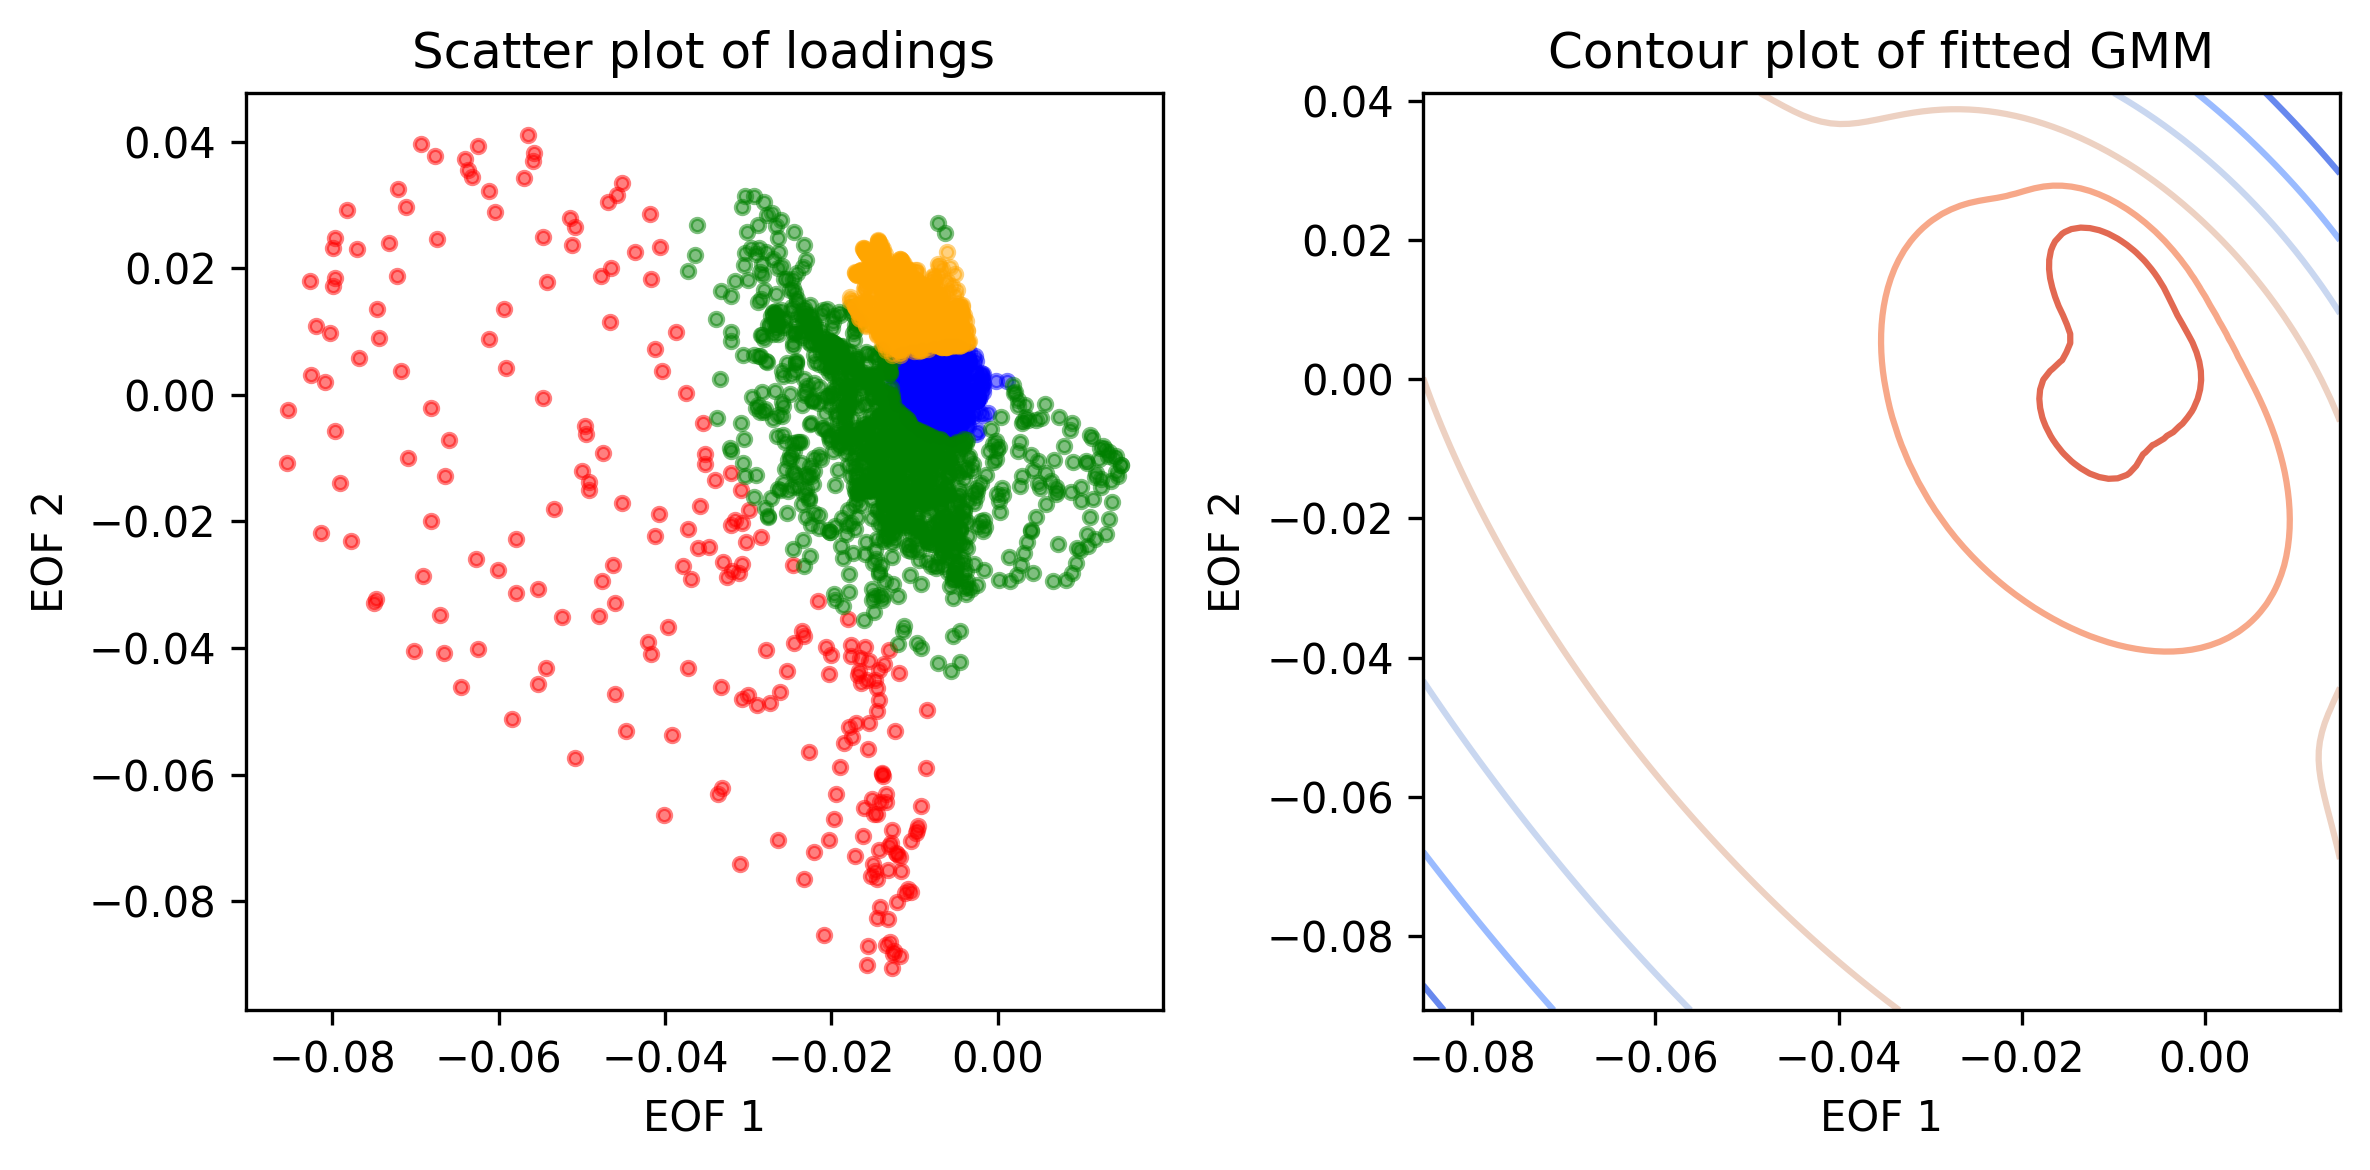

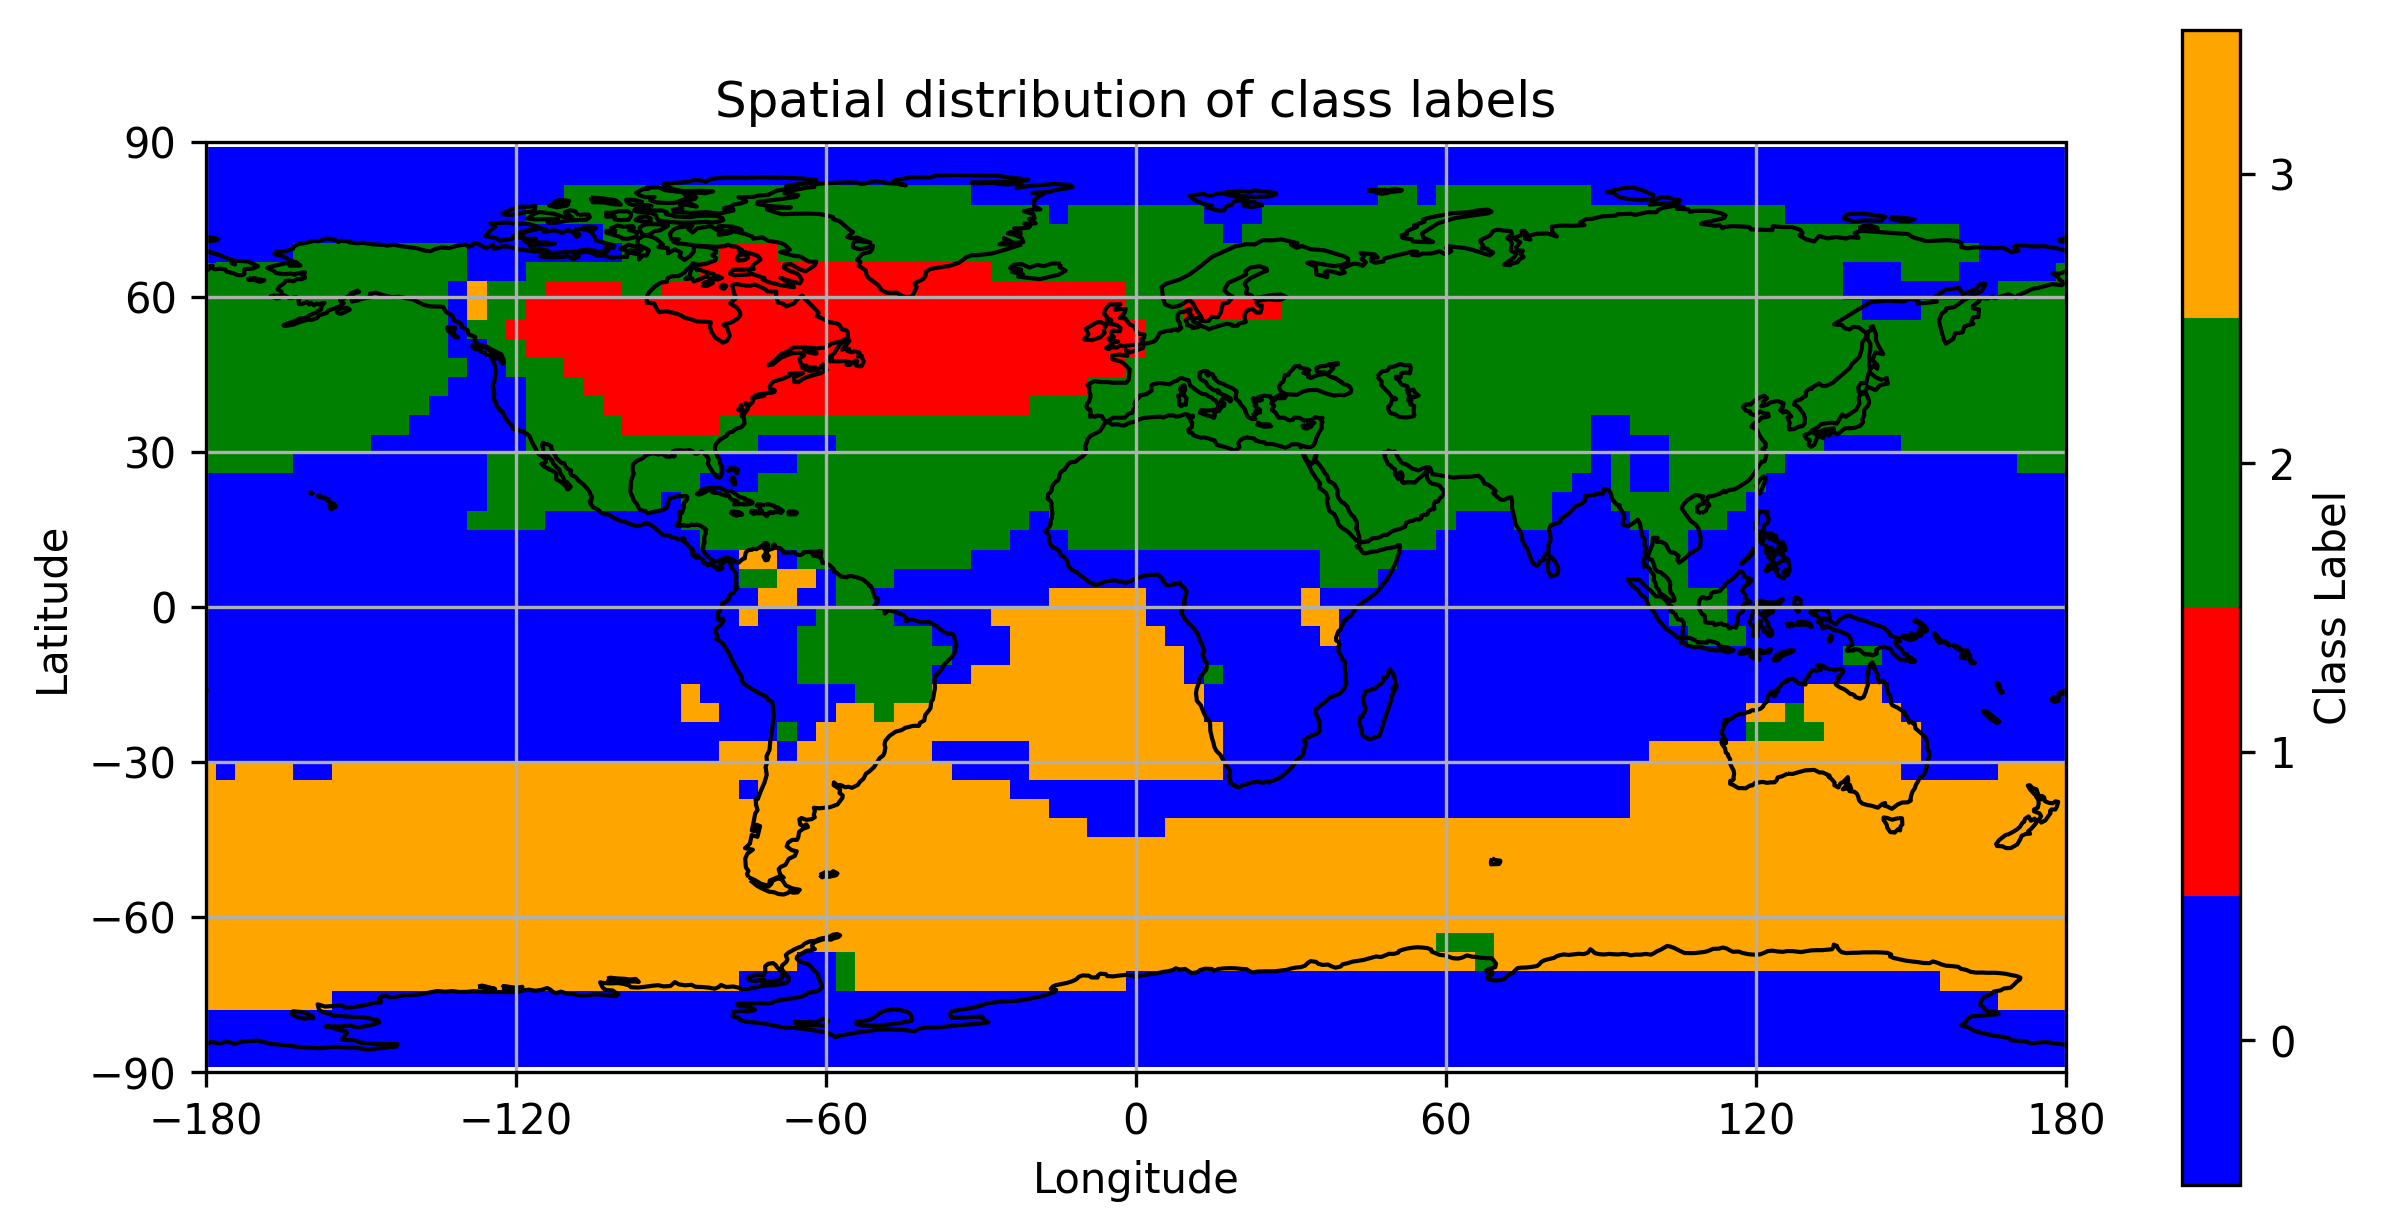

In [57]:
ds_EOFs_GMM=GMM4EOFS(EOFs, ds_sat,n_components=4)

from toolbox import GMM_functions as gf
gf.plot_labels(ds_EOFs_GMM)

shape of the weight: (48,)


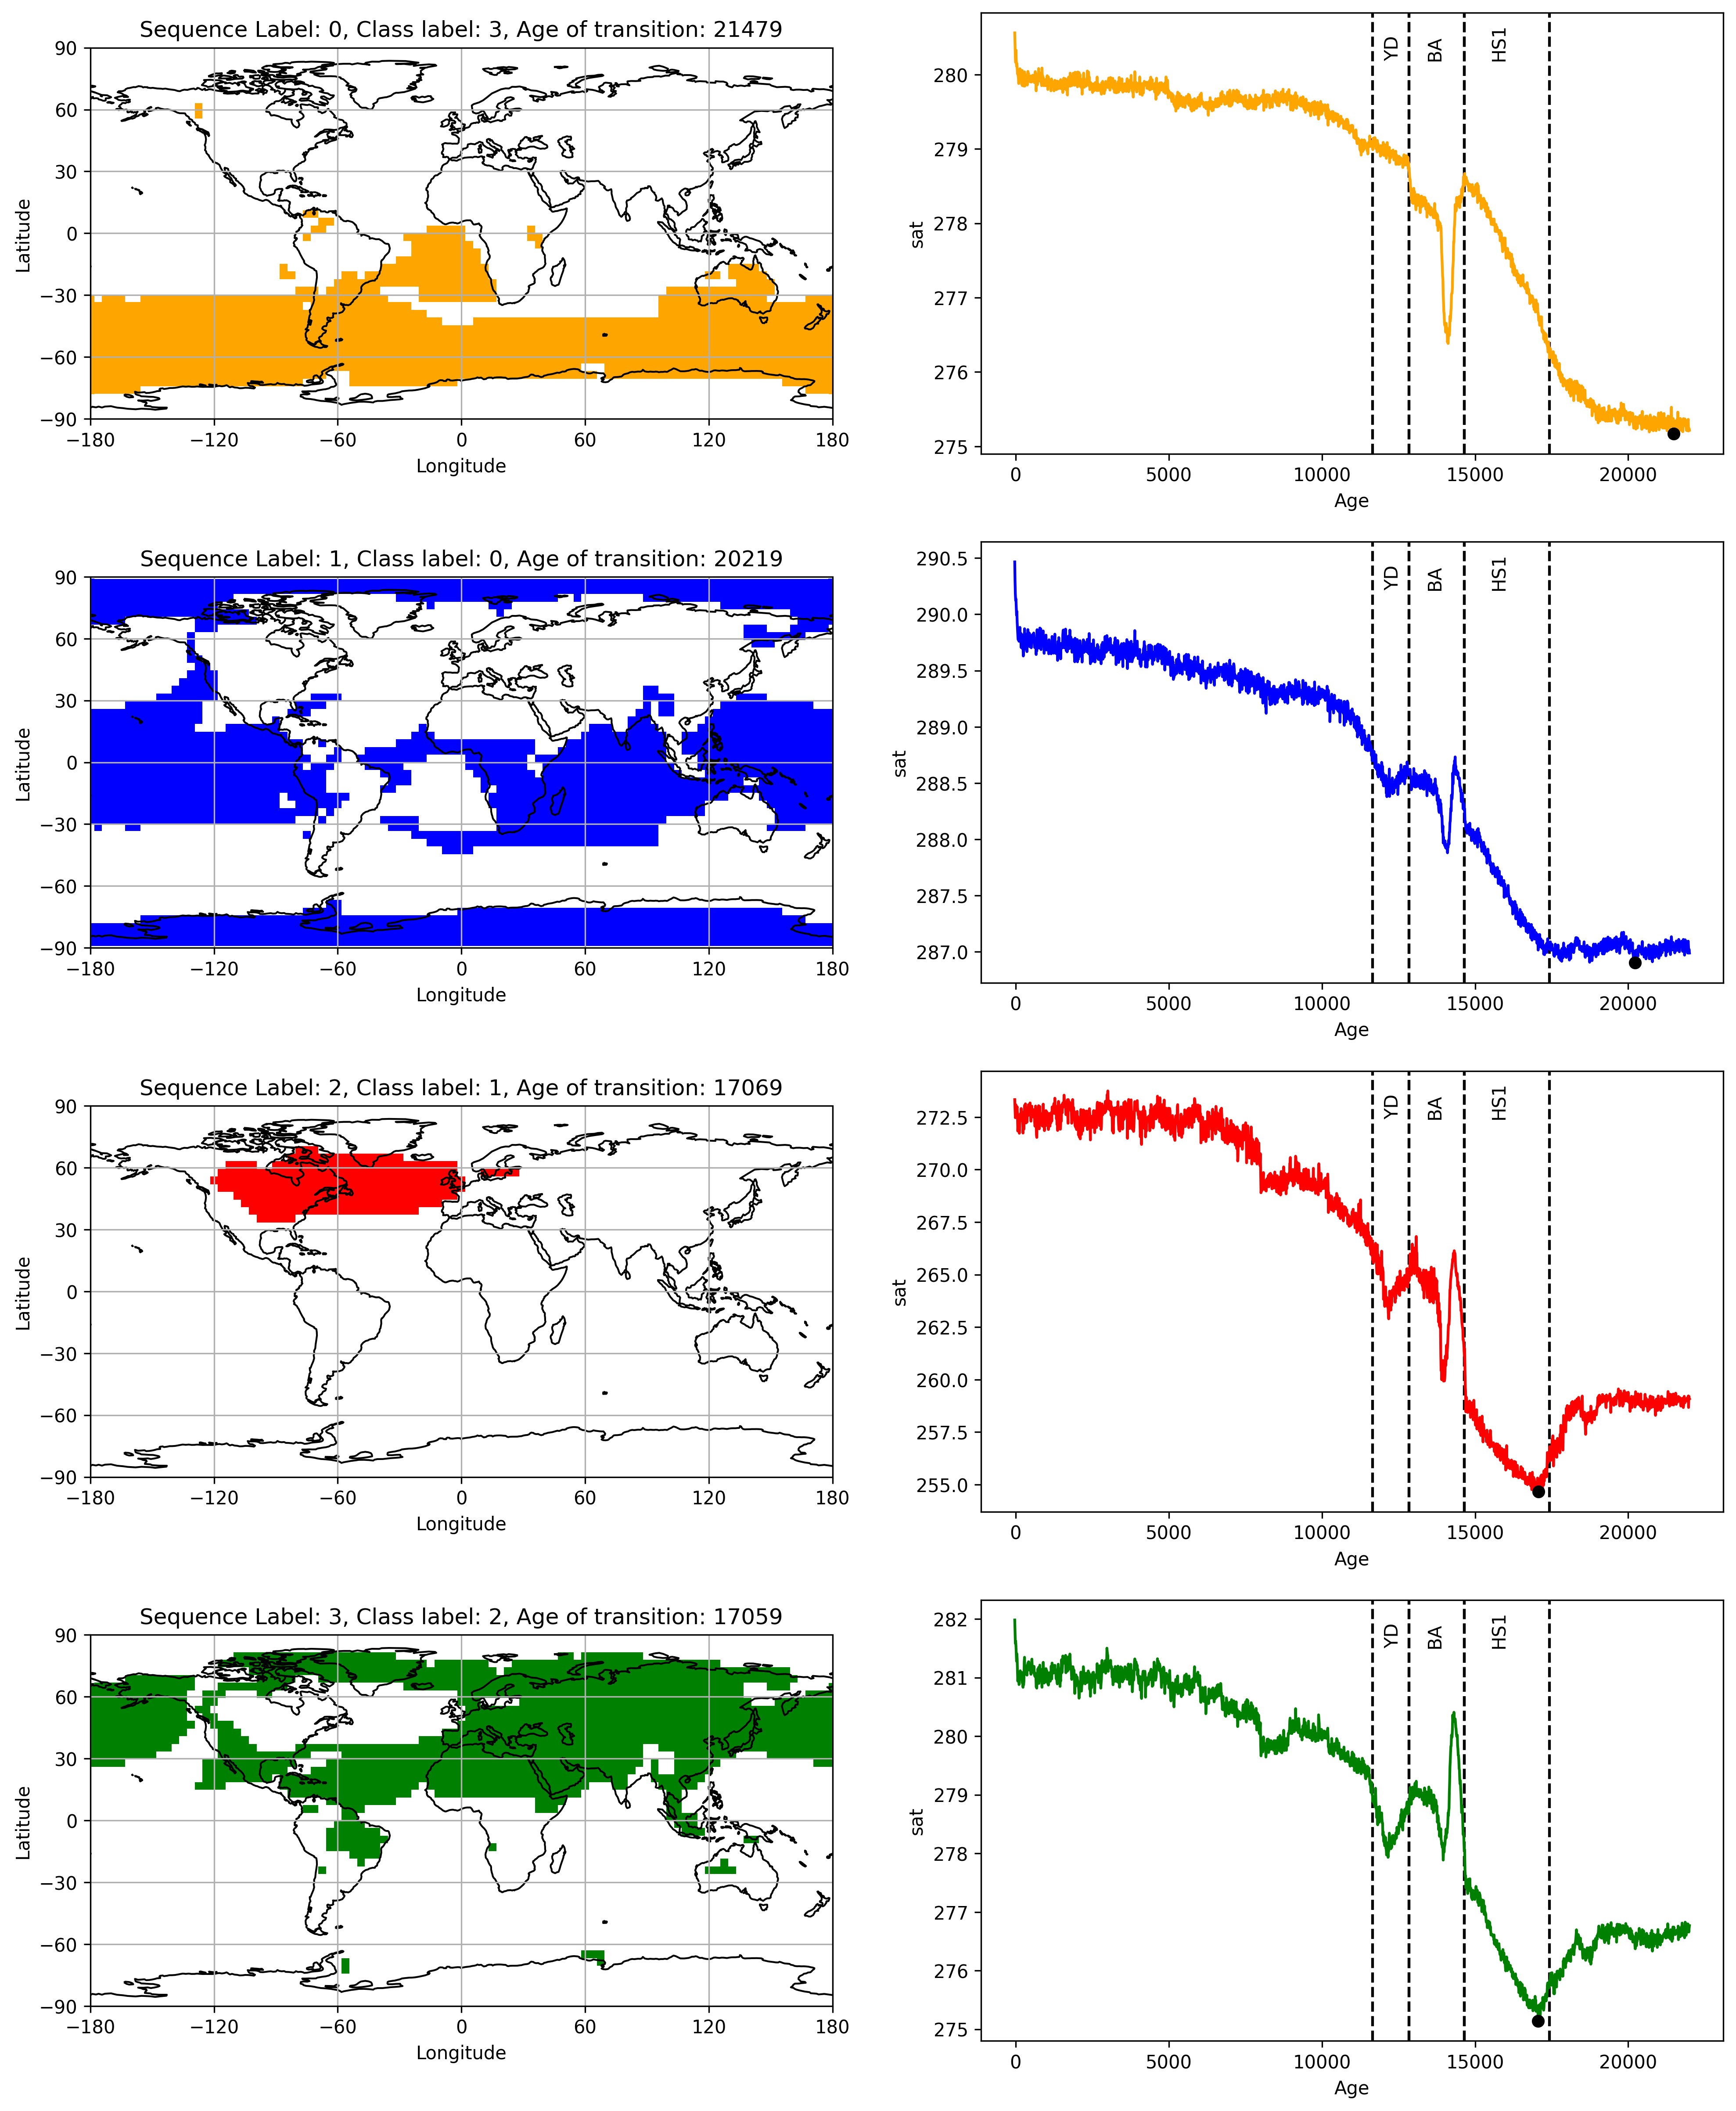

In [60]:
from toolbox import GMM_functions as gf
gf.plot_all_label_at_sequence(ds_EOFs_GMM,variable='sattest')